Kepler Mapper is one of a number of libraries that performs topological data analytic functions. This library is based on the mapper algorithm. (More about the algorithm can be read here: https://research.math.osu.edu/tgda/mapperPBG.pdf)

Mapper is used to determine how multiple independent variables relate to a single dependent variable. Here, we'll see how we can look at various data points for Chicago voters, and see how they map to the outcome of the 2015 Mayoral Election. 

In [11]:
import kmapper as km
import numpy as np
import matplotlib.pyplot as plt
import sys, os
from kmapper.plotlyviz import plotlyviz 
import networkx as nx
from sklearn import preprocessing, datasets 
from numpy import genfromtxt
import pandas as pd
import geopandas as gpd
from statistics import mode
import folium
import mapclassify
import IPython
import re

First, we read in the Chicago data, and do a little data exploration. 

In [12]:
chicago_mayoral = pd.read_csv("../data/Chicago_mayoral.csv")

In [13]:
for col in chicago_mayoral.columns: print(col)
chicago_mayoral.head()

full_text
precinct
shape_area
shape_len
ward
TOTPOP
NH_WHITE
NH_BLACK
NH_AMIN
NH_ASIAN
NH_NHPI
NH_OTHER
NH_2MORE
HISP
H_WHITE
H_BLACK
H_AMIN
H_ASIAN
H_NHPI
H_OTHER
H_2MORE
VAP
HVAP
WVAP
BVAP
AMINVAP
ASIANVAP
NHPIVAP
OTHERVAP
2MOREVAP
TOTHH
LESS_10K
10K_15K
15K_20K
20K_25K
25K_30K
30K_35K
35K_40K
40K_45K
45K_50K
50K_60K
60K_75K
75K_100K
100K_125K
125K_150K
150K_200K
200K_MORE
JOINID
TOTV_19
JOYCE_19
VALLAS_19
WILSON_19
PRECK_19
DALEY_19
MCCART_19
CHICO_19
MEND_19
ENYIA_19
FORD_19
SALGRIF_19
LHGTFT_19
FIORETTI_1
KOZLAR_19
TOTV_RO15
RO_E15
RO_G15
TOTV_G15
EMAN_G15
WILS_G15
FIORET_G15
GARCIA_G15
WALLS_G15
TOTPOP19
NH_WHITE19
NH_BLACK19
NH_AMIN19
NH_ASIAN19
NH_NHPI19
NH_OTHER19
NH_2MORE19
HISP19
H_WHITE19
H_BLACK19
H_AMIN19
H_ASIAN19
H_NHPI19
H_OTHER19
H_2MORE19
Ward_Prec
MAY19LL
MAY19TP
COUNTY
HVAP_pct
WVAP_pct
BVAP_pct
AMINVAP_pct
ASIANVAP_pct
NHPIVAP_pct
OTHERVAP_pct
2MOREVAP_pct
LESS_10K_pct
10K_15K_pct
15K_20K_pct
20K_25K_pct
25K_30K_pct
30K_35K_pct
35K_40K_pct
40K_45K_pct
45K_50K_pct


,full_text,precinct,shape_area,shape_len,ward,TOTPOP,NH_WHITE,NH_BLACK,NH_AMIN,NH_ASIAN,...,45K_50K_pct,50K_60K_pct,60K_75K_pct,75K_100K_pct,100K_125K_pct,125K_150K_pct,150K_200K_pct,200K_MORE_pct,GARCIA_G15_pct,EMAN_G15_pct
0,41027,27.0,3.090762e+08,139749.430317,41.0,2197.199822,1842.147074,37.523810,0.0,78.768500,...,3.088277e-02,0.071385,0.155162,0.116651,0.063415,0.041462,1.938787e-02,0.020865,0.467532,0.389610
1,5025,25.0,2.569525e+07,35894.522176,5.0,1179.000035,40.000002,1063.000032,2.0,3.000000,...,1.741558e-02,0.107800,0.075687,0.066644,0.055029,0.022873,3.010790e-02,0.077477,0.171779,0.435583
2,48041,41.0,1.248113e+06,4917.914119,48.0,2077.999953,789.999985,584.999994,4.0,190.999993,...,2.343280e-02,0.071516,0.045449,0.014157,0.033428,0.011520,2.857899e-02,0.025868,0.311189,0.377622
3,3024,24.0,5.716768e+06,12629.240176,3.0,1677.000001,17.000000,1595.000001,2.0,3.000000,...,2.091312e-02,0.048259,0.054365,0.024377,0.041899,0.011571,4.505476e-10,0.001364,0.351111,0.475556
4,2045,45.0,4.762711e+05,2986.071131,2.0,1448.999997,830.999998,353.000000,4.0,172.999999,...,7.938806e-10,0.027556,0.063741,0.054931,0.123686,0.057728,4.960015e-02,0.029612,0.619718,0.262911


The file has columns for the percentage of each racial group's voting age population (VAP) in each precinct, and columns for the number of households are in each salary range in each precinct. We want to extract some of those columns to choose our input data for mapper. 

Note that, we want percents as opposed to counts, because counts without context don't give us a lot of info. 

If we know Rahm Emanuel had 150 votes in precinct 1 and there were 150 white voters, It'll make a huge difference whether the total precinct population was close to 150 or something much larger. 

In [14]:
vap_cols = [col for col in chicago_mayoral if "VAP_pct" in col]

In [15]:
salary_cols = [col for col in chicago_mayoral.columns if "K_pct" in col or col == "200K_MORE_pct"]

Now, we're going to create 2 dataframes to run through the entire mapper process. 

One dataframe will map demographic shares in each precinct to the percent of support for Chuy Garcia. The other will map household salary shares to the precinct level support for Garcia. 

In [16]:
chicago_dem_df = chicago_mayoral[["BVAP_pct", "HVAP_pct", "WVAP_pct", "GARCIA_G15_pct"]]
chicago_salary_df = chicago_mayoral[salary_cols + ["GARCIA_G15_pct"]]

In [17]:
chicago_salary_df.head()

,LESS_10K_pct,10K_15K_pct,15K_20K_pct,20K_25K_pct,25K_30K_pct,30K_35K_pct,35K_40K_pct,40K_45K_pct,45K_50K_pct,50K_60K_pct,60K_75K_pct,75K_100K_pct,100K_125K_pct,125K_150K_pct,150K_200K_pct,200K_MORE_pct,GARCIA_G15_pct
0,0.054155,0.097632,0.053159,0.073450,6.945268e-02,0.044972,0.028811,0.059156,3.088277e-02,0.071385,0.155162,0.116651,0.063415,0.041462,1.938787e-02,0.020865,0.467532
1,0.170550,0.097315,0.073075,0.047740,6.911747e-02,0.021744,0.029584,0.037842,1.741558e-02,0.107800,0.075687,0.066644,0.055029,0.022873,3.010790e-02,0.077477,0.171779
2,0.180925,0.138861,0.102196,0.063180,9.606658e-02,0.064423,0.046237,0.054160,2.343280e-02,0.071516,0.045449,0.014157,0.033428,0.011520,2.857899e-02,0.025868,0.311189
3,0.272632,0.192903,0.094790,0.112528,1.715004e-02,0.035026,0.042264,0.029960,2.091312e-02,0.048259,0.054365,0.024377,0.041899,0.011571,4.505476e-10,0.001364,0.351111
4,0.297892,0.166479,0.034874,0.012253,4.635531e-10,0.050721,0.013196,0.017730,7.938806e-10,0.027556,0.063741,0.054931,0.123686,0.057728,4.960015e-02,0.029612,0.619718


Keplermapper cannot read an input dataframe, but we can easily turn our dataframes into numpy arrays. 

In [18]:
chicago_dem_data = np.array(chicago_dem_df)
chicago_salary_data = np.array(chicago_salary_df)

In [19]:
chicago_dem_data.shape

(2069, 4)

In [20]:
chicago_salary_data.shape

(2069, 17)

Now, we want to choose the columns number to project our data to. Here, the data is projected to the precinct level support for Chuy Garcia, so we want to get the index of that column out of the dataframe. 

In [21]:
dem_col_num = chicago_dem_df.columns.get_loc("GARCIA_G15_pct")
salary_col_num = chicago_salary_df.columns.get_loc("GARCIA_G15_pct")

So, we want to take our variable of interest (the election outcome), and fit a mapper object to this data. In order to use mapper, we have to turn our dataframe into a numpy array. 

Then we choose the column number from the original data that we're interested in mapping to. Here, we're going to look at the voting outcomes for Rahm Emanuel, and see how that relates to race in a precinct.

Here we call fit transform to actually do the projection. We are projecting to a specific column of the input dataset, but other values that could be passed to projection are "mean" and "sum" which would take the mean or the sum of each of the values for each precinct in the input data. 

In [22]:
chicago_dem_mapper = km.KeplerMapper(verbose=1)
chicago_dem_projected = chicago_dem_mapper.fit_transform(chicago_dem_data, projection = [dem_col_num], scaler=None)

chicago_salary_mapper = km.KeplerMapper(verbose=1)
chicago_salary_projected = chicago_salary_mapper.fit_transform(chicago_salary_data, projection = [salary_col_num], scaler=None)


KeplerMapper(verbose=1)
..Composing projection pipeline of length 1:
	Projections: [3]
	Distance matrices: False
	Scalers: None
..Projecting on data shaped (2069, 4)

..Projecting data using: [3]
KeplerMapper(verbose=1)
..Composing projection pipeline of length 1:
	Projections: [16]
	Distance matrices: False
	Scalers: None
..Projecting on data shaped (2069, 17)

..Projecting data using: [16]


In [23]:
chicago_dem_projected.shape

(2069, 1)

As I explained a bit before, once the data is in a projected space, the next part of the Mapper algorithm involves covering that space with n dimensional hypercubes (where n is the dimension of the input data). The hypercubes will have a user-specified percent of overlap with each other. 

You can play around with choosing the percents, but if you have a large percent of overlap, more of your data will end up in multiple clusters, and the clusters themselves will be bigger. 

The number of cubes can also be interesting to play with. If you don't have enough cubes, the clusters you end up with may not be very useful as things that aren't as similar will get grouped together. With too many cubes, you could end up with very small clusters that don't have a lot of overlap. 


In [24]:
n_cubes = 40
p_overlap = .2

In [25]:
chicago_dem_graph = chicago_dem_mapper.map(chicago_dem_projected, chicago_dem_data, cover = km.Cover(n_cubes=n_cubes, perc_overlap=p_overlap))
chicago_salary_graph = chicago_salary_mapper.map(chicago_salary_projected, chicago_salary_data, cover = km.Cover(n_cubes=n_cubes, perc_overlap=p_overlap))

Mapping on data shaped (2069, 4) using lens shaped (2069, 1)

Creating 40 hypercubes.

Created 46 edges and 54 nodes in 0:00:00.037566.
Mapping on data shaped (2069, 17) using lens shaped (2069, 1)

Creating 40 hypercubes.

Created 35 edges and 39 nodes in 0:00:00.027372.


Now we can use the Kepler Mapper visualization tool to see what our graph looks like. 

This will output to an html file that you can download, open in your browser, and use to interact with the data. 


In [39]:
%%capture
chicago_dem_mapper.visualize(chicago_dem_graph, path_html = "chicago_demographics_garcia.html",
                    title="Demographic Data for Chicago", color_values=chicago_dem_data[:,2], color_function_name='WVAP_pct', X = chicago_dem_data, X_names = ["BVAP_pct", "HVAP_pct", "WVAP_pct", "GARCIA_G15_pct"])

In [27]:
chicago_dem_data

array([[0.01638645, 0.08647394, 0.85055109, 0.46753247],
       [0.90997831, 0.01952278, 0.03687636, 0.17177914],
       [0.2777471 , 0.18221977, 0.41413584, 0.31118881],
       ...,
       [0.01257862, 0.02695418, 0.90745732, 0.80225989],
       [0.12275253, 0.11005208, 0.4402141 , 0.1503268 ],
       [0.01310044, 0.64737991, 0.32969433, 0.65217391]])

In [38]:
%%capture
chicago_salary_mapper.visualize(chicago_salary_graph, path_html = "chicago_salary_garcia.html", 
                    title="Salary Data for Chicago", color_values=chicago_salary_data[:,chicago_salary_df.columns.get_loc('200K_MORE_pct')], color_function_name='200K_MORE_pct',X = chicago_salary_data, X_names = salary_cols + ["GARCIA_G15_pct"])

We can also manually inspect the graph. 

Each cluster has a specific name, and I'll just print the first 10. 

In [29]:
list(chicago_dem_graph["nodes"].keys())[:10]

['cube1_cluster0',
 'cube2_cluster0',
 'cube2_cluster1',
 'cube3_cluster0',
 'cube3_cluster1',
 'cube4_cluster0',
 'cube5_cluster0',
 'cube6_cluster0',
 'cube7_cluster0',
 'cube8_cluster0']

Once you've created the mapper object, you can get specific cluster information. 

The cluster details in the mapper html page shows the row number of each of the rows in the initial geodataframe that were included in the cluster. 

In [30]:
cluster_info = chicago_dem_mapper.data_from_cluster_id('cube33_cluster1', chicago_dem_graph, chicago_dem_data)

In [31]:
len(chicago_dem_graph['nodes']) #['cube33_cluster1']

54

In [32]:
cluster_df = pd.DataFrame(cluster_info, columns=chicago_dem_df.columns)

We can use these indices to get the rows from the original dataframe that make up the clusters. 

In [33]:
chicago_mayoral[["WVAP_pct", "BVAP_pct", "GARCIA_G15_pct", "EMAN_G15_pct"]][chicago_mayoral.index.isin(chicago_dem_graph['nodes']['cube8_cluster0'])]

,WVAP_pct,BVAP_pct,GARCIA_G15_pct,EMAN_G15_pct
8,0.017781,0.953770,0.225806,0.648746
9,0.034988,0.558699,0.227545,0.383234
13,0.703172,0.105740,0.242647,0.389706
41,0.045833,0.744643,0.238532,0.623853
44,0.013830,0.690426,0.228571,0.400000
...,...,...,...,...
2032,0.866167,0.006424,0.235088,0.480702
2036,0.916667,0.017857,0.239544,0.467681
2050,0.639746,0.190136,0.237354,0.385214
2054,0.759194,0.086690,0.241667,0.412500


In [34]:
cluster_df.head()

,BVAP_pct,HVAP_pct,WVAP_pct,GARCIA_G15_pct
0,0.010814,0.882186,0.095048,0.765125
1,0.057448,0.885613,0.042196,0.753623
2,0.024902,0.823722,0.127785,0.757576
3,0.030981,0.888124,0.070568,0.758197
4,0.323720,0.620764,0.033165,0.764151


I've created a little function here to plot the averages of a list of desired values within each cluster vs. another column of interest. 

i.e. plotting mean population of each demographic group in a cluster vs. the mean vote total within that cluster

In [35]:
def graph_cluster_means(graph, columns, col_of_interest): 
  colors = ["red", "coral", "bisque", "orange", "yellow", "goldenrod", "olivedrab", "springgreen", "steelblue"]
  votes = []
  cluster_means = [[] for col in range(len(columns))]
  fig, ax = plt.subplots(1,1, figsize=(7, 5))
  for cluster in graph['nodes'].keys():
    cluster_indices = graph['nodes'][cluster]
    subset = chicago_mayoral[chicago_mayoral.index.isin(cluster_indices)]
    votes.append(np.mean(subset[col_of_interest]))
    for i, col in enumerate(columns):
      cluster_means[i].append(np.mean(subset[col]))
  for i, cluster in enumerate(cluster_means): 
    plt.scatter(cluster, votes, color=colors[i], label = columns[i])
  plt.xlabel("Demographic share")
  plt.ylabel(f"{col_of_interest}")
  plt.legend()

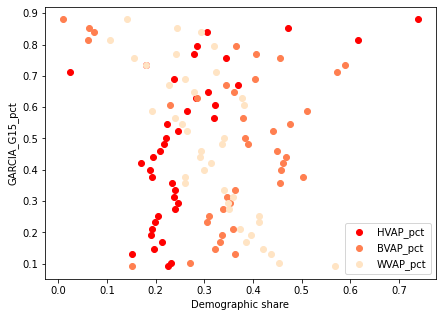

In [36]:
graph_cluster_means(chicago_salary_graph, ["HVAP_pct", "BVAP_pct", "WVAP_pct"], "GARCIA_G15_pct")

Import the Chicago precinct shapefile:

In [40]:
precinct_geodf = gpd.read_file("../data/precincts_shapefile/PRECINCTS_2012.shp")

DriverError: Unable to open ../data/PRECINCTS_2012.shx or ../data/PRECINCTS_2012.SHX. Set SHAPE_RESTORE_SHX config option to YES to restore or create it.

In [ ]:
chicago_mayoral[(chicago_mayoral["ward"]== 15) & (chicago_mayoral["precinct"]== 6)]
precinct_geodf[(precinct_geodf["WARD"]== 15) & (precinct_geodf["PRECINCT"]== 6)]

In [ ]:
idxs = list()

for node in chicago_dem_graph["nodes"].values():
  idxs = idxs + list(node)

print(2069 - len(set(idxs)))

# Visualizing Mapper Clusters on a Map

The following function generates an interactive map using the folium library with layers corresponding to some set of precincts

In [ ]:
### expects a dict of the form "layer_name": [...node_idxs...], ...
def generate_layered_map(layer_dict, default_open):
  map = folium.Map()

  for layer_name, precinct_idxs in layer_dict.items():
    precincts = chicago_mayoral[chicago_mayoral.index.isin(precinct_idxs)]
    precinct_ids = precincts["full_text"].apply(lambda n : str(n).rjust(5, "0"))

    geodf_clusters = precinct_geodf[precinct_geodf["FULL_TEXT"].isin(precinct_ids)]
    map = geodf_clusters.explore(m = map, name=layer_name, show=default_open)

  folium.LayerControl().add_to(map)
  map.fit_bounds(map.get_bounds(), padding=(20, 20))

  return map


Passing the list of nodes of the resulting graph from the mapper algorithm will produce a map where each layer corresponds to one node of the graph and contains all of the precincts in that cluster

In [ ]:
generate_layered_map(chicago_dem_graph['nodes'], False)

It's a pain to get much information from manually clicking through clusters, so we can use networkx to get more interesting layers out of the topological information contained in the graph, i.e. in the example below, the connected components of the graph

In [ ]:
conn_comp_layers = dict()
comp_sizes = list()

G = km.to_nx(chicago_dem_graph)

for C in sorted(nx.connected_components(G), key=len, reverse=True):
  subgraph = nx.subgraph(G, C)

  comp_precincts = list()



  for name, data in subgraph.nodes.items():
    comp_precincts = comp_precincts + data['membership']
  
  comp_size = len(list(subgraph.nodes))
  comp_sizes = comp_sizes + [comp_size]

  count = comp_sizes.count(comp_size)

  if count > 1:
    layer_name = ("%i cluster component (%i)" %(comp_size, count-1))
  else:
    layer_name = ("%i cluster component" %(comp_size))


  conn_comp_layers[layer_name] = comp_precincts

generate_layered_map(conn_comp_layers, True)

To hopefully see more interesting geographic clustering, we can try to identify my topologically interesting subsets of vertices. The following code generates layers based on the basis of cycles for the mapper graph. Since the largest connected component of this graph is more or less a linear graph with small cycles and forks, it makes sense to consider the two "halves" of the loop. We will do this by treating the vertices of a cycle which are cut points of the larger graph as the "branch" and  "merge" points of the two paths through the cycle.

In [ ]:
cycle_layers = dict()
cycles       = nx.cycle_basis(G)
cut_points   = list(nx.articulation_points(G))

for cycle in cycles:
  cycle_graph = nx.subgraph(G, cycle)
  join_verts = list(set(cut_points) & set(cycle_graph))

  intersection_precincts = G.nodes[join_verts[0]]["membership"] + G.nodes[join_verts[1]]["membership"]
  
  paths = list(nx.all_simple_paths(cycle_graph, join_verts[0], join_verts[1]))
  paths_as_precincts = list()

  for path in paths:
    path = list(set(path) - set(join_verts))
    path_precincts = list()

    path_n = 0

    for node in path:
      path_precincts += G.nodes[node]["membership"]
      if node.split("_")[1] == "cluster1": path_n = 1

    paths_as_precincts.insert(path_n, path_precincts)

  layer_name_prefix = join_verts[0].split("_")[0] + " - " + join_verts[1].split("_")[0] + " cycle "

  for n, path in enumerate(paths_as_precincts):
    layer = dict()
    name = layer_name_prefix + "path " + str(n)

    cycle_layers[name] = path

  intersection_layer = layer_name_prefix + "branch/merge points"
  cycle_layers[intersection_layer] = intersection_precincts

generate_layered_map(cycle_layers, False)